In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from scipy import ndimage as ndi

from skimage import (
    exposure, io, morphology, color, feature, filters, util, segmentation
)
import math
from scipy import signal
from skimage.filters import threshold_multiotsu
from skimage.morphology import disk
from skimage.filters import threshold_li
from skimage import measure
import pandas as pd
import os
#import PyDIP as dip
import math
import re
from glob import glob
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
#from skimage.morphology import watershed
from skimage.segmentation import random_walker
from scipy import ndimage

In [2]:
def slice(im3d):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen=[]
    for i in range(stack_size):
        if hist[i] >= (ups['peak_heights'][0]+2*ups2['peak_heights'][0])/3:
            plt.vlines(i,0,max(hist), colors='y')
            chosen.append(i)
    return chosen

In [3]:
def slice_manual(im3d,start,stop):
    stack_size = im3d.shape[0]
    hist=[]
    for i in range(stack_size):
        hist.append(im3d[i,:,:].mean())
    plt.plot(range(stack_size),hist, '.-')
    #if len(signal.argrelextrema(np.array(hist), np.greater)) <= 2:
    grad1 = np.gradient(hist)
    peaks, ups = signal.find_peaks(grad1,max(grad1)*0.1)
    peaks2, ups2 = signal.find_peaks(hist,max(hist)*0.1)
    #plt.vlines([maximums],0,max(hist), colors='r')
    plt.vlines([peaks2],0,max(hist), colors='b')
    chosen = range(start,stop)
    for i in chosen:
        plt.vlines(i,0,max(hist), colors='y')
    return chosen

In [11]:
def display(im3d, cmap="gray", step=1, chosen = None):
    if chosen is None: 
        chosen = []
    stack_size = im3d.shape[0]
    cols = 5
    rows = math.ceil((stack_size/cols))
    
    h , axes = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols, 3*rows))
    #print(h)
    #p1 = get(h,'Position')
    #annotation('rectangle',p1,'FaceAlpha',.2,'FaceColor','red','EdgeColor','red') 
    vmin = im3d.min()
    vmax = im3d.max()
    enum = 0
    for ax, image in zip(axes.flatten(), im3d[::step]):
        ax.imshow(image, cmap=cmap, vmin=vmin, vmax=vmax)
        if enum in chosen:
            for axis in ['top','bottom','left','right']:
                #ax.spines[axis].set_linewidth(0.5)
                ax.spines[axis].set_color("red")
                ax.spines[axis].set_linewidth(5)
        ax.set_xticks([])
        ax.set_yticks([])
        enum += 1
    #plt.savefig('foo.png')
    

In [12]:
def display_slice(im, cmap="gray", step=1, chosen = None, savefig = False):
    h , axes = plt.subplots(1,1)
    vmin = im.min()
    vmax = im.max()
    enum = 0
    axes.imshow(im, cmap=cmap, vmin=vmin, vmax=vmax)

In [13]:
#info, background fluorescence measurements

#measurement of non-cells regions in the cyclin B1 channel of 5 G2 cells

#5325 rep1 08-11, 1.606
#5325 rep1 10-12 1, 4.919
#5325 rep2 01-15, 18 2.406
#5325 rep1 07-10, 1.179
#5325 rep1 10-12 2, 2.399

#mean background = 2.5018 >>> normalise to this value



In [14]:
ResultsDir = ("/groups/gerlich/members/PaulBatty/Paper_preparation/figures/quantify_mean_intensities/results/wt/g2/")

In [15]:
pixel_size = (28.3679)
#this is the number of pixels per micron, change the pixel size according to your specific image. You can find this out by clicking show info for the image in Fiji
scaling_factor = pixel_size**2

def get_features(images):
    '''
    - Expects list of images in the TIF format, with each image being a single slice or projection.
    - The script will cycle through images in a given input folder and can be used to calculate the area of the nucleus and the total intensity of the two channels, with the final output a dataframe containing the image name
    
    - The script is designed to threshold nuclei and create a mask of the nucleus. The area of the DNA counterstain is calculated and converted to microns by dividing by the scaling factor.
    - The scaling factor can be determined by the user in ImageJ, and is the number of pixels per micron.
    - The thresholded mask is applied to the channels of interest. All pixel intensity values are extracted for the two channels within this mask and then the mean intensity for the channel within the mask is calculated.
    - The output is a dataframe, with each row corresponding to a given input image.
    '''
    
    #Set up variables as empty lists
    all_data = []
    regions_filtered_data = []
    #labels = []
    #Set up dictionary accumulator to append temporary dictionaries to a dataframe at the end
    dict_accumulator = []
    #read in files
    for image in images:
        #read in list of images
        data = io.imread(image)
        
        #select channels, in this case, scc1 = channel 1, sir hoechst = channel 2, using zero indexing
        cycb1 = data[:, :, :, 0]
        h3s10p = data[:, :, :, 1]
        edu = data[:, :, :, 2]
        hoechst = data[:, :, :, 3]
        
        #define stack size
        #define central slice using integer division
        #threshold central slice

        
        centre_of_mass = ndimage.center_of_mass(hoechst)
        com = centre_of_mass[0]
        if com % 1 <= 0.5:
            centre = math.floor(com)
        else:
            centre = math.ceil(com)


        #centre = np.argmax(hist)
        central_hoechst = hoechst[centre, :, :]
        central_cycb1 = cycb1[centre, :, :]  
        central_edu = edu[centre, :, :]
        central_h3s10p  = h3s10p[centre, :, :]  

        #threshold the hoechst channel, using the threshold li method to create a binary mask. Everything with a value greater than the threshold will be included.
        thresh = threshold_li(central_hoechst)
        #binary_mask = central_hoechst > thresh
        
                
        #remove small holes by performing closing. Binary_closing faster for binary images.
        binary_mask = morphology.binary_closing(central_hoechst > thresh, disk(10)) 
        
        binary_mask = ndimage.binary_fill_holes(binary_mask).astype(int)
        
        #remove debris and other small objects below a certain size e.g. micronuclei
        remove_debris = morphology.remove_small_objects(binary_mask, 3000)
        
        
        #erode binary mask with disk size of 20. This is optional, shrinks mask slightly to remove edge artefacts
        #eroded = morphology.erosion(binary_mask, disk(5))   
        
        #Generate labels
        labels = measure.label(remove_debris)
        #Measure properties
        props = measure.regionprops(labels)
        #Make sure only largest labels is taken into account in the thresholding
        props.sort(key=lambda x: x.area, reverse=True)
        if len(props) > 1:
            for prop in props[1:]:
                labels[prop.coords[:,0], prop.coords[:,1]] = 0
        labels[labels!=0] = 1
        remove_debris = labels

        #display slices
        display_slice(central_hoechst)
        #display_slice(central_cycb1)
        display_slice(remove_debris)

        area = props[0].area
        nuclear_area = area/scaling_factor
        flat_central_cycb1 = central_cycb1.flatten()
        flat_central_h3s10p = central_h3s10p.flatten()
        flat_central_edu = central_edu.flatten()
        flat_central_hoechst = central_hoechst.flatten()
        flat_binary = remove_debris.flatten()
        all_data = pd.DataFrame(zip(flat_central_cycb1, flat_central_h3s10p, flat_central_edu, flat_central_hoechst, flat_binary),columns=["cycb1", "h3s10p", "edu", "hoechst", "binary"])
        
        #filter relevant data into new dataframe. Only values within the binary mask are retained.

        regions_filtered_data = all_data.loc[all_data.binary > 0]
        
        #Extract mean for the channels and calculate total intensity
        
        mean_cycb1 = regions_filtered_data.cycb1.mean()
        mean_h3s10p = regions_filtered_data.h3s10p.mean()
        mean_edu = regions_filtered_data.edu.mean()
        mean_hoechst = regions_filtered_data.hoechst.mean()

        image_name = image
        #standard_dev_sir_hoechst = regions_filtered_data.sir_hoechst.std()
        #standard_dev_scc1 = regions_filtered_data.scc1.std()
        #coeff_variance_sir_hoechst = (regions_filtered_data.sir_hoechst.std())/(regions_filtered_data.sir_hoechst.mean())
        #coeff_variance_scc1 = (regions_filtered_data.scc1.std())/(regions_filtered_data.scc1.mean())
        #print(image_name)
        temp_dict = {
            "image_name": image_name,
            "nuclear_area" : nuclear_area,
            "mean_cycb1" : mean_cycb1,
            "mean_h3s10p" : mean_h3s10p, 
            "mean_edu" : mean_edu, 
            "mean_hoechst" : mean_hoechst,
            #"coeff_variance_sir_hoechst" : coeff_variance_sir_hoechst,
            #"coeff_variance_scc1" : coeff_variance_scc1
            #"total_scc1" : total_scc1,
            #"total_sir_hoechst" : total_sir_hoechst
        }
        dict_accumulator.append(temp_dict)
    all_dataframes = pd.DataFrame(dict_accumulator)
    #Add conditon column to dataframes
    all_dataframes["condition"] = "wt_g2_hemi_15h"
    #return (all_dataframes)
        
    #return all_dataframes
    # os.chdir changes working directory-> can lead to unexpected behaviour use os.path.join or just string together
    #ResultsDir = "./"
    #safe variante
    all_dataframes.to_csv(os.path.join(ResultsDir + "wt_g2_hemi_h3s10p_15h_5618.csv"), index = False)
    return all_dataframes
    #sting variant
    #final_df.to_csv(os.path.join(ResultsDir + "summary_hoechst+scc1.csv", index = False)
    #Why?
    


Your will run into problems if you have more then one region in the image.
To solve this you need to:
- select the biggest region (to get the one you want)
- skip if regions (to not crash if empty)

/opt/conda/lib/python3.9/site-packages/skimage/_shared/utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/skimage/_shared/utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/skimage/_shared/utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/skimage/_shared/utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)
/opt/conda/lib/python3.9/site-packages/skimage/_shared/utils.py:112: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  retu

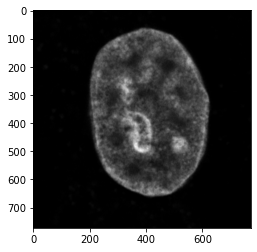

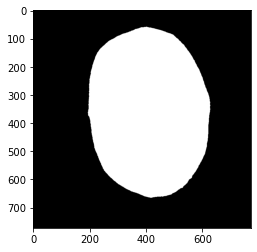

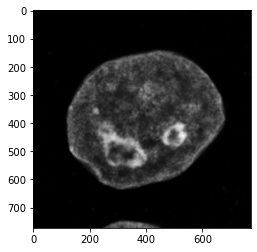

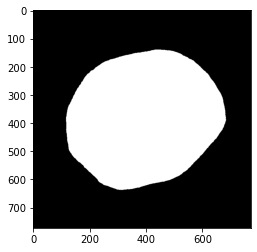

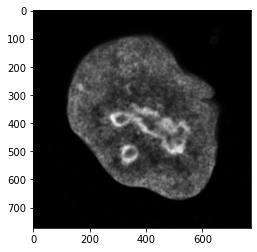

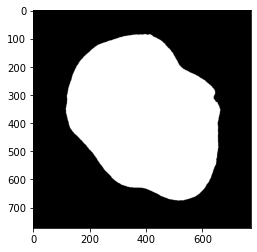

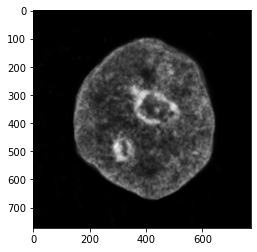

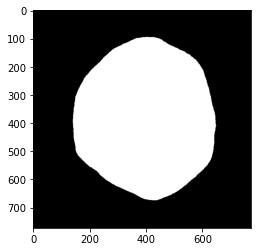

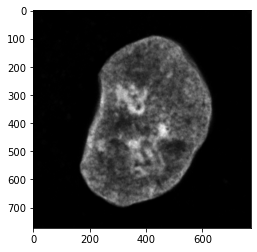

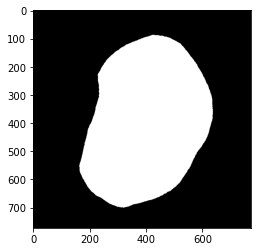

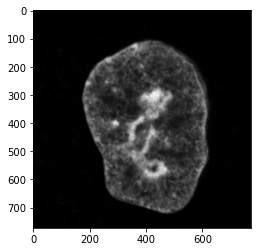

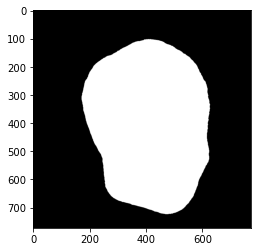

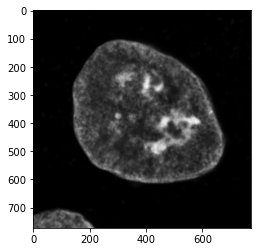

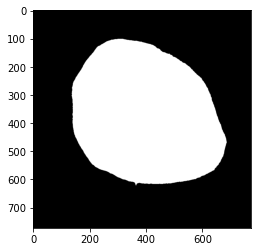

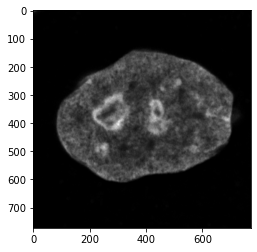

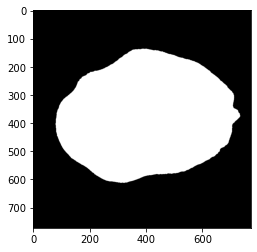

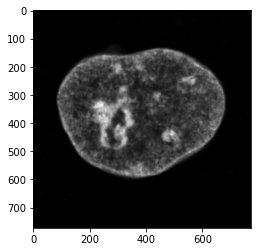

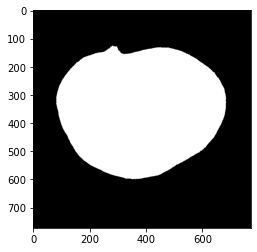

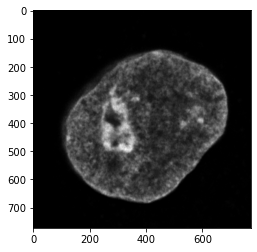

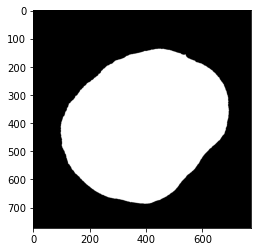

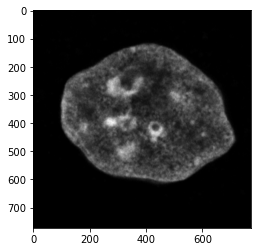

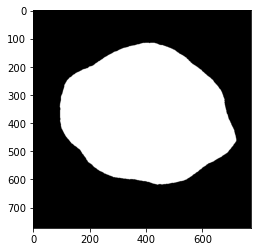

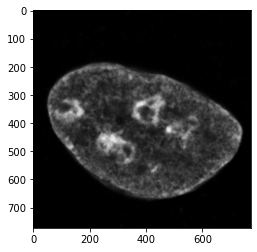

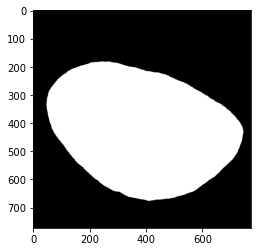

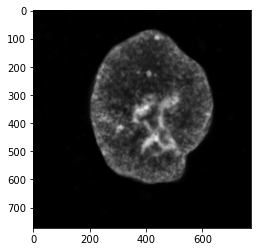

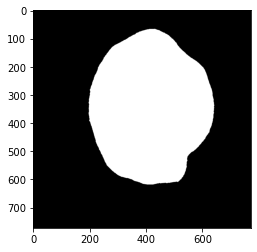

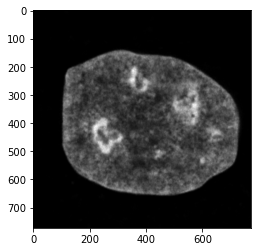

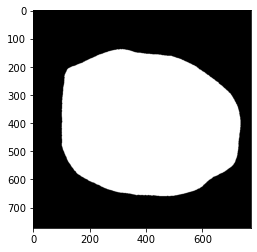

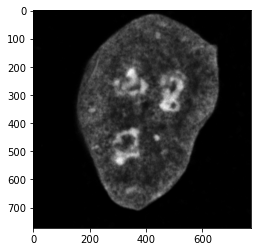

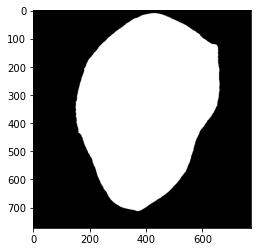

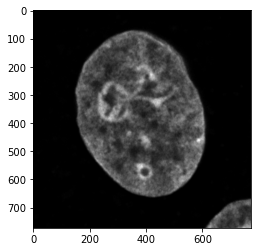

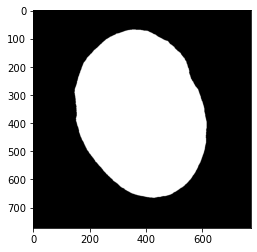

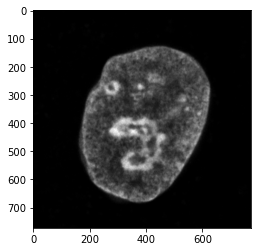

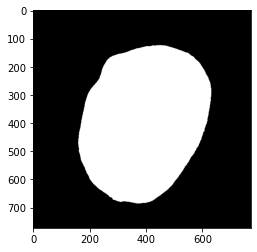

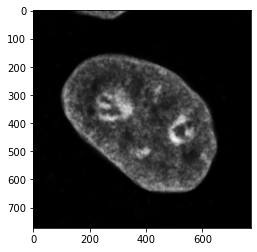

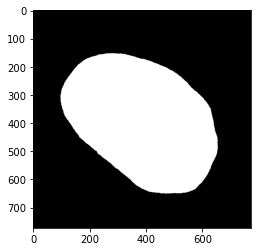

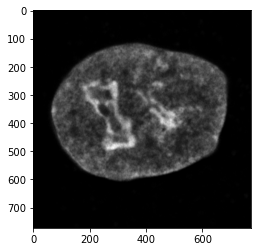

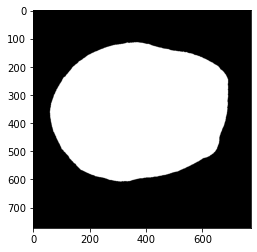

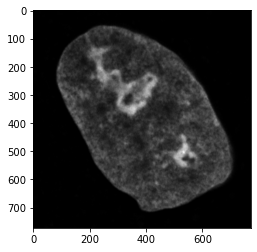

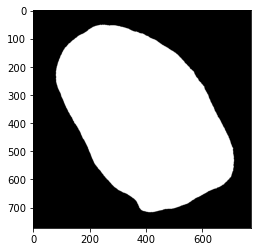

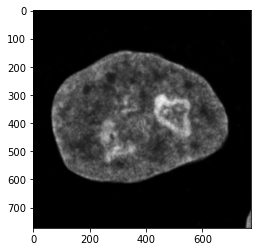

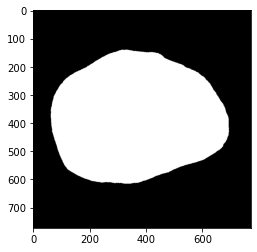

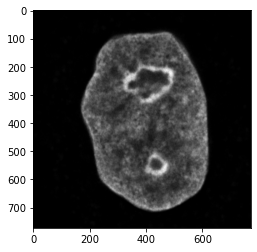

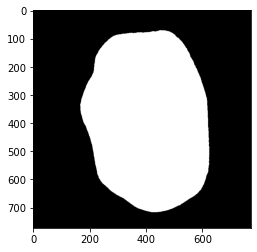

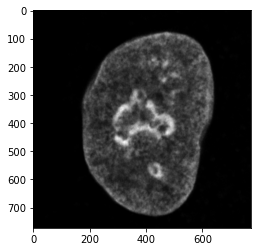

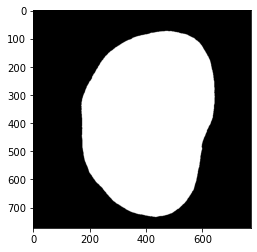

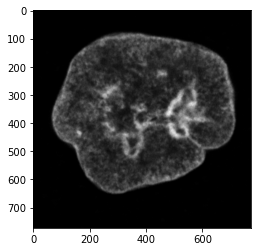

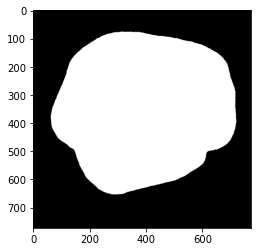

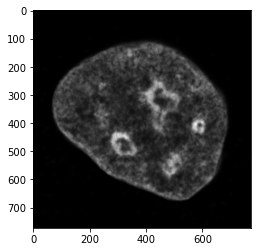

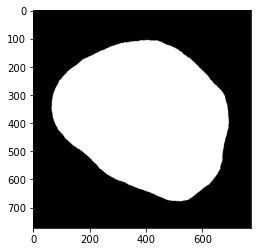

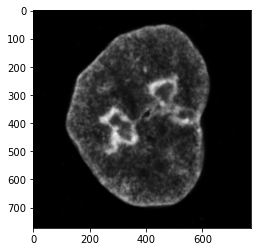

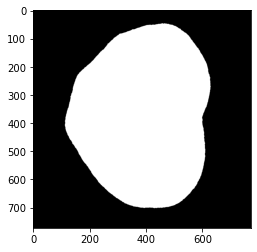

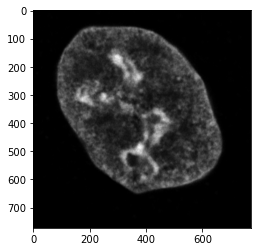

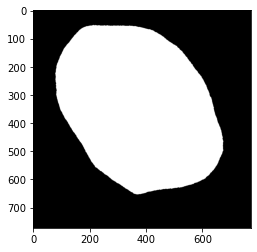

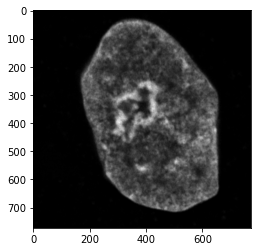

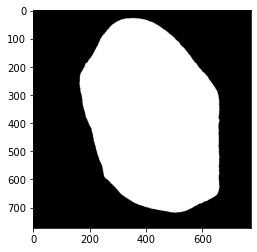

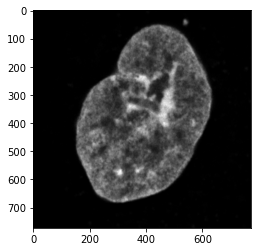

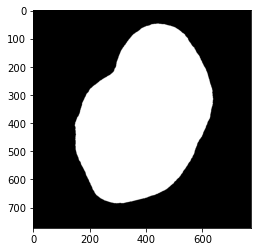

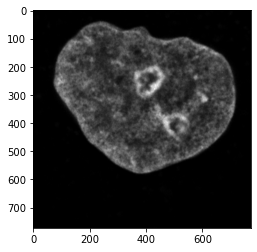

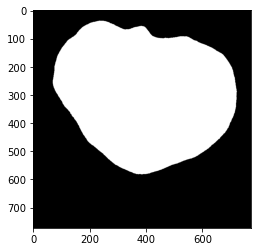

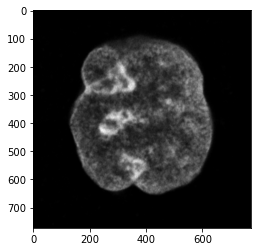

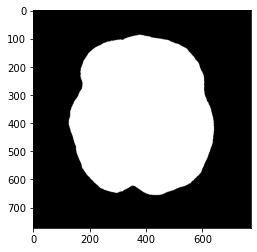

In [16]:
inpath = ("/groups/gerlich/experiments/Experiments_005600/005618/images/tifs_registered_background_subtracted/wt/hemi_g2_15h_h3s10/")
os.chdir(inpath)
images = glob('*.tif', recursive=True)
result = get_features(images)



In [17]:
result

,image_name,nuclear_area,mean_cycb1,mean_h3s10p,mean_edu,mean_hoechst,condition
0,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,256.699776,77.924885,33.769562,960.665910,2039.006830,wt_g2_hemi_15h
1,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,263.345419,76.107784,37.977525,919.958561,2019.361030,wt_g2_hemi_15h
2,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,291.282470,79.384077,42.711731,681.190891,2015.372439,wt_g2_hemi_15h
3,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,276.908844,94.155897,38.322470,978.421542,1630.182194,wt_g2_hemi_15h
4,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,259.019786,92.232869,40.448127,1245.156786,2112.659552,wt_g2_hemi_15h
5,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,268.620429,79.986867,35.776083,974.840569,1614.261074,wt_g2_hemi_15h
6,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,268.557055,96.248503,32.299711,820.618380,1818.890365,wt_g2_hemi_15h
7,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,277.917868,61.201497,33.769583,648.311204,1869.828697,wt_g2_hemi_15h
8,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,269.713953,86.635534,30.468051,573.690333,1671.475312,wt_g2_hemi_15h
9,220919_5618_wt_hemi_g2_ro_h3s10p_cycb1_zoom4_8...,295.629228,100.195167,29.978912,502.523808,1515.647887,wt_g2_hemi_15h


In [33]:
#finding out the channel parameters

In [12]:
image = ("/groups/gerlich/experiments/Experiments_005300/005389/Images/TIFs_registered_background_subtracted/WT/hemi_prophase/early/220207_5389_WT_c1_rep1_prophase_60min_stlc_hemi_zoom5-01-47.czi #03.tif_registered.tif")
data = io.imread(image)

#select channels, h2bac1 = channel1, mpm2 = channel2, Hoechst = channel 3
cycb1 = data[:, :, :, 0]
hoechst = data[:, :, :, 3]

#define stack size
#define central slice using integer division
#threshold central slice

data.shape

(77, 740, 740, 4)

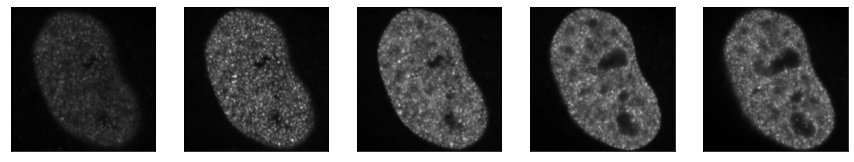

In [10]:
display(scc1)

In [11]:
stack_size = sir_hoechst.shape[0]
hist = []
for i in range(stack_size):
    hist.append(sir_hoechst[i,:,:].mean())


centre = np.argmax(hist)
central_sir_hoechst = sir_hoechst[centre, :, :]
central_scc1 = scc1[centre, :, :]  

In [14]:
standard_deviation = central_scc1.std()

In [15]:
standard_deviation

601.9063549171113